<a href="https://colab.research.google.com/github/stephan-strate/sentiment-fine-foods/blob/master/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np

In [11]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/sentiment-fine-foods/sentiment-fine-foods.csv", delimiter=",", header=0)
print("Dataset has {:,} rows".format(df.shape[0]))

Dataset has 568,454 rows


In [8]:
df[["HelpfulnessNumerator", "HelpfulnessDenominator", "Score", "Text"]].sample(5)

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text
212446,0,0,5,I absolutely LOVE this seasoning! It is the be...
251938,0,0,2,I was trying these as a change of pace from th...
536710,0,0,5,a gasp from my past. i can't believe these are...
169822,0,0,5,"These have such delicious flavor, it is really..."
388079,0,0,2,What we expected: That the corn beef was exac...


Clean data for future use with BERT
1. clean HTML tags from texts to prevent bloating of tokenizer, as BERT does not know HTML tags
2. remove duplicate reviews (using Text column)

In [12]:
import re

size_dataset = len(df.index)

html_affected_rows = 0
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  if raw_html != cleantext:
    global html_affected_rows
    html_affected_rows += 1
  return cleantext

# clean html content of texts
df.Text = df.Text.apply(cleanhtml)
print("Cleaned {:,} rows from html ({} %)".format(html_affected_rows, round(html_affected_rows / size_dataset * 100)))

# removing duplicates
df.drop_duplicates(subset="Text", inplace=True)
rows_removed = size_dataset - len(df.index)
print("Removed {:,} duplicates ({} %)".format(rows_removed, round(rows_removed / size_dataset * 100)))

Cleaned 147,324 rows from html (26 %)
Removed 174,900 duplicates (31 %)


In [15]:
print("Dataset size after cleaning: {:,} / {:,} rows ({} %)".format(len(df.index), size_dataset, round(len(df.index) / size_dataset * 100)))

Dataset size after cleaning: 393,554 / 568,454 rows (69 %)


Analyse data regarding helpfulness

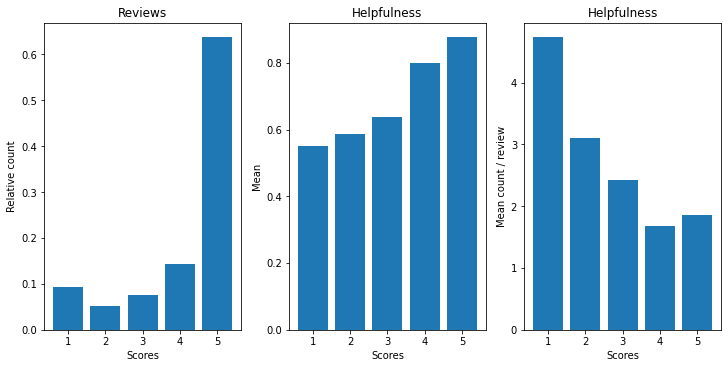

In [ ]:
import matplotlib.pyplot as plt
import statistics

label_values = set(data.Score.values)

fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(10, 5))

label_value_counts = data.Score.value_counts()
axs[0].bar(list(map(str, label_values)), list(map(lambda x: label_value_counts.get(x) / len(data.index), label_values)))
axs[0].set_title("Reviews")
axs[0].set_xlabel("Scores")
axs[0].set_ylabel("Relative count")

def mean_helpfulness(label):
  subset = data[data.Score.eq(label)]
  return statistics.mean(filter(lambda x: x is not None, map(lambda index: index.HelpfulnessNumerator / index.HelpfulnessDenominator if index.HelpfulnessDenominator > 0 else None, subset.itertuples(index=True))))

axs[1].bar(list(map(str, label_values)), list(map(mean_helpfulness, label_values)))
axs[1].set_title("Helpfulness")
axs[1].set_xlabel("Scores")
axs[1].set_ylabel("Mean")

def count_helpful(label):
  subset = data[data.Score.eq(label)]
  return sum(map(lambda index: index.HelpfulnessDenominator, subset.itertuples(index=True))) / len(subset.values)

axs[2].bar(list(map(str, label_values)), list(map(count_helpful, label_values)))
axs[2].set_title("Helpfulness")
axs[2].set_xlabel("Scores")
axs[2].set_ylabel("Mean count / review")

plt.show()

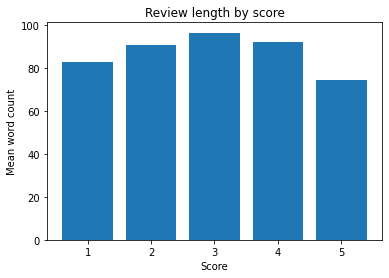

In [ ]:
groups = data.groupby("Score")

plt.bar(list(map(str, label_values)), list(map(lambda x: np.mean(list(map(lambda y: len(y.split(" ")), x[1].Text.values))), groups)))
plt.xlabel("Score")
plt.ylabel("Mean word count")
plt.title("Review length by score")
plt.show()

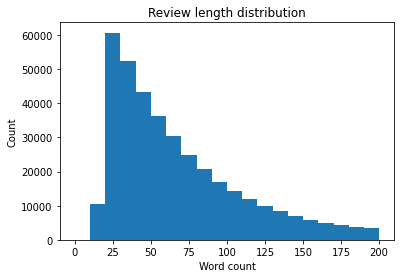

In [ ]:
plt.hist(list(map(lambda x: len(x.split(" ")), data.Text.values)), range=(0, 200), bins=20)
plt.xlabel("Word count")
plt.ylabel("Count")
plt.title("Review length distribution")
plt.show()

In [ ]:
data_helpful = data[(data.HelpfulnessDenominator > 0) & (data.HelpfulnessNumerator / data.HelpfulnessDenominator > 0.5)]
data_helpful.shape

(161210, 10)

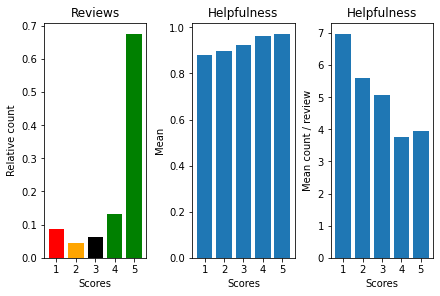

In [ ]:
fig, axs = plt.subplots(1, 3, constrained_layout=True)

label_value_counts = data_helpful.Score.value_counts()
axs[0].bar(list(map(str, label_values)), list(map(lambda x: label_value_counts.get(x) / len(data_helpful.index), label_values)), color=["red", "orange", "black", "green", "green"])
axs[0].set_title("Reviews")
axs[0].set_xlabel("Scores")
axs[0].set_ylabel("Relative count")

def mean_helpfulness(label):
  subset = data_helpful[data_helpful.Score.eq(label)]
  return statistics.mean(filter(lambda x: x is not None, map(lambda index: index.HelpfulnessNumerator / index.HelpfulnessDenominator if index.HelpfulnessDenominator > 0 else None, subset.itertuples(index=True))))

axs[1].bar(list(map(str, label_values)), list(map(mean_helpfulness, label_values)))
axs[1].set_title("Helpfulness")
axs[1].set_xlabel("Scores")
axs[1].set_ylabel("Mean")

def count_helpful(label):
  subset = data_helpful[data_helpful.Score.eq(label)]
  return sum(map(lambda index: index.HelpfulnessDenominator, subset.itertuples(index=True))) / len(subset.values)

axs[2].bar(list(map(str, label_values)), list(map(count_helpful, label_values)))
axs[2].set_title("Helpfulness")
axs[2].set_xlabel("Scores")
axs[2].set_ylabel("Mean count / review")

plt.show()

In [ ]:
data_not_helpful = data[(data.HelpfulnessDenominator > 0) & (data.HelpfulnessNumerator / data.HelpfulnessDenominator <= 0.5)]
data_not_helpful.shape

(47873, 10)

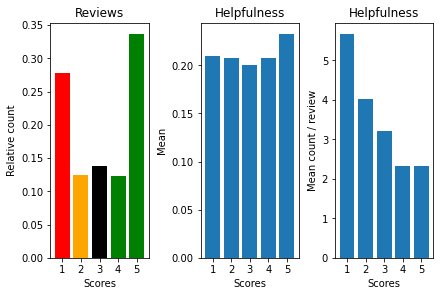

In [ ]:
fig, axs = plt.subplots(1, 3, constrained_layout=True)

label_value_counts = data_not_helpful.Score.value_counts()
axs[0].bar(list(map(str, label_values)), list(map(lambda x: label_value_counts.get(x) / len(data_not_helpful.index), label_values)), color=["red", "orange", "black", "green", "green"])
axs[0].set_title("Reviews")
axs[0].set_xlabel("Scores")
axs[0].set_ylabel("Relative count")

def mean_helpfulness(label):
  subset = data_not_helpful[data_not_helpful.Score.eq(label)]
  return statistics.mean(filter(lambda x: x is not None, map(lambda index: index.HelpfulnessNumerator / index.HelpfulnessDenominator if index.HelpfulnessDenominator > 0 else None, subset.itertuples(index=True))))

axs[1].bar(list(map(str, label_values)), list(map(mean_helpfulness, label_values)))
axs[1].set_title("Helpfulness")
axs[1].set_xlabel("Scores")
axs[1].set_ylabel("Mean")

def count_helpful(label):
  subset = data_not_helpful[data_not_helpful.Score.eq(label)]
  return sum(map(lambda index: index.HelpfulnessDenominator, subset.itertuples(index=True))) / len(subset.values)

axs[2].bar(list(map(str, label_values)), list(map(count_helpful, label_values)))
axs[2].set_title("Helpfulness")
axs[2].set_xlabel("Scores")
axs[2].set_ylabel("Mean count / review")

plt.show()